In [1]:
import copy
import numpy as np
import os
import palettable
import verdict

/home1/03057/zhafen/.local/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.patheffects as path_effects
import matplotlib.gridspec as gridspec
import matplotlib.transforms as transforms

In [3]:
import analysis_config

In [4]:
import linefinder.analyze_data.worldlines as a_worldlines
import linefinder.analyze_data.worldline_set as a_w_set
import linefinder.analyze_data.plot_worldlines as p_worldlines

/opt/apps/intel17/python/2.7.13/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [5]:
import linefinder.utils.presentation_constants as p_constants
import linefinder.utils.file_management as file_management
import linefinder.config as linefinder_config

In [6]:
import galaxy_dive.plot_data.plotting as plotting
import galaxy_dive.utils.astro as astro_utils
import galaxy_dive.utils.utilities as utilities
import galaxy_dive.utils.executable_helpers as exec_helpers
import galaxy_dive.plot_data.qual_colormaps as qual_colormaps

# Load Data

In [7]:
snum, galdef = exec_helpers.choose_config_or_commandline(
    [ analysis_config.SNUM, analysis_config.GALDEF ]
)
print( 'Using snum {}, galdef {}'.format( snum, galdef ) )

Using snum 172, galdef _galdefv3


In [8]:
tag_tail = '_CGM_snum{}'.format( snum )

In [9]:
ahf_index = 600

In [10]:
ind = ahf_index - snum

In [11]:
# Load the a helper for loading files easily
file_manager = file_management.FileManager( project='CGM_origin' )

In [12]:
defaults, variations = file_manager.get_linefinder_analysis_defaults_and_variations(
    tag_tail, 
    sim_names = analysis_config.SIM_NAMES,
    galdef = galdef,
)

In [13]:
defaults

{'ahf_index': 600,
 'data_dir': '/scratch/03057/zhafen/linefinder_data/core/m12i_res7100/data',
 'halo_data_dir': '/scratch/03057/zhafen/core/m12i_res7100/halo',
 'ids_tag': 'm12i_CGM_snum172',
 'main_halo_id': 0,
 'ptracks_tag': 'm12i_CGM_snum172',
 'tag': 'm12i_CGM_snum172_galdefv3'}

In [14]:
variations

{'m10q': {'ahf_index': 600,
  'data_dir': '/scratch/03057/zhafen/linefinder_data/core/m10q_res250/data',
  'halo_data_dir': '/scratch/03057/zhafen/core/m10q_res250/halo',
  'ids_tag': 'm10q_CGM_snum172',
  'main_halo_id': 0,
  'ptracks_tag': 'm10q_CGM_snum172',
  'tag': 'm10q_CGM_snum172_galdefv3'},
 'm10y': {'ahf_index': 600,
  'data_dir': '/scratch/03057/zhafen/linefinder_data/core/m10y_res250/data',
  'halo_data_dir': '/scratch/03057/zhafen/core/m10y_res250/halo',
  'ids_tag': 'm10y_CGM_snum172',
  'main_halo_id': 0,
  'ptracks_tag': 'm10y_CGM_snum172',
  'tag': 'm10y_CGM_snum172_galdefv3'},
 'm10z': {'ahf_index': 600,
  'data_dir': '/scratch/03057/zhafen/linefinder_data/core/m10z_res250/data',
  'halo_data_dir': '/scratch/03057/zhafen/core/m10z_res250/halo',
  'ids_tag': 'm10z_CGM_snum172',
  'main_halo_id': 0,
  'ptracks_tag': 'm10z_CGM_snum172',
  'tag': 'm10z_CGM_snum172_galdefv3'},
 'm11a': {'ahf_index': 600,
  'data_dir': '/scratch/03057/zhafen/linefinder_data/core/m11a_res210

In [15]:
w_set = a_w_set.WorldlineSet( defaults, variations )

# Analyze Data

# Look at Density Profiles

In [16]:
w_set.data_object.retrieve_halo_data()
halo_masses = w_set.data_object.m_vir.inner_item( snum )

In [17]:
# Start from a fresh slate
w_set.data_object.data_masker.clear_masks( True )
# Choose only gas
w_set.data_object.data_masker.mask_data( 'PType', data_value=linefinder_config.PTYPE_GAS )

# Set up classifications
classification_list = copy.copy( p_constants.CLASSIFICATIONS_CGM_ORIGIN )
# classification_list.remove( 'is_CGM_satellite' )
classification_list.insert( 0, 'is_in_CGM' )

In [18]:
# Set up mass bins
mass_bins = [ 'm12', 'm11', 'm10' ]

In [19]:
# Loop through classifications and get raw data

radii = verdict.Dict({})
densities = verdict.Dict({})
metallicities = verdict.Dict({})
masses = verdict.Dict({})
for classification in classification_list:

    print( classification )
    
    radii[classification] = w_set.data_object.get_selected_data(
        'R',
        scale_key = 'Rvir',
        scale_a_power = 1.,
        scale_h_power = -1.,
        sl = (slice(None),ind),
        classification = classification,
    )
    
    densities[classification] = w_set.data_object.get_selected_data(
        'HDen',
        sl = (slice(None),ind),
        classification = classification,
    )
    
    metallicities[classification] = w_set.data_object.get_selected_data(
        'Z_asplund',
        sl = (slice(None),ind),
        classification = classification,
    )
    
    masses[classification] = w_set.data_object.get_selected_data(
        'M',
        sl = (slice(None),ind),
        classification = classification,
    )

is_in_CGM
is_CGM_IGM_accretion
is_CGM_wind
is_CGM_satellite_wind
is_CGM_satellite_ISM


In [20]:
# Calculate the volumes. Note that the units are weird for these volumes, since it's mass
# divided by a number density
volumes = masses / densities

In [21]:
# Choose one of the plotters to plot data with. It doesn't matter which one,
# because we'll be passing data
w_plotter = w_set['m12i']
w = w_plotter.data_object

In [22]:
# Get the minimum radii to plot to
split_radii = radii['is_in_CGM'].split_by_dict( linefinder_config.MASS_BINS )
min_radii = {}
for key, item in split_radii.items():
    n_min = 3
    
    percentile = n_min / float( len( item ) ) * 100.
    print( percentile )
    
    min_radii[key] = np.percentile( item.min().array(), percentile  )

50.0
50.0
37.5


# Data Storage

In [23]:
all_data = verdict.Dict({})

### Combined Plot

/opt/apps/intel17/python/2.7.13/lib/python2.7/site-packages/scipy-0.19.0-py2.7-linux-x86_64.egg/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/opt/apps/intel17/python/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in power


File saved at /home1/03057/zhafen/papers/CGM_origin/figures/CGM_den_profile_snum172.pdf


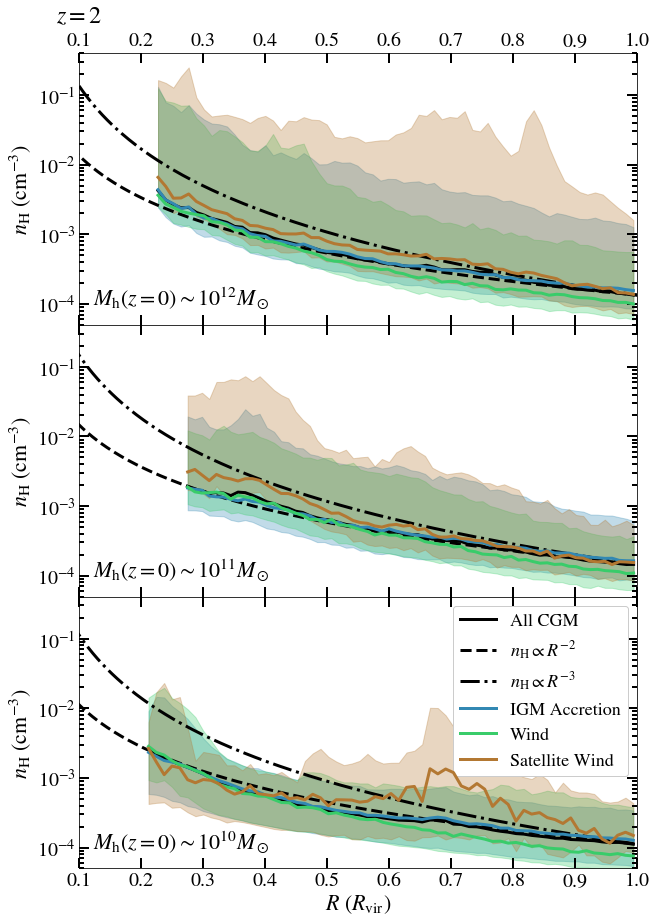

In [24]:
n_rows = len( mass_bins )

fig = plt.figure( figsize=(10,n_rows*5), facecolor='white' ) 
main_ax = plt.gca()

gs = gridspec.GridSpec( n_rows, 1 )

gs.update(wspace=0.025, hspace=0.0001)

den_data = verdict.Dict({})

handles, labels = [], []
for j, mass_bin in enumerate( mass_bins ):
    
    den_data[mass_bin] = verdict.Dict({})

    for i, classification in enumerate( classification_list ):
                
        ax = plt.subplot(gs[j,0])

        radii_bin = radii[classification].split_by_dict( linefinder_config.MASS_BINS )[mass_bin]
        densities_bin = densities[classification].split_by_dict( linefinder_config.MASS_BINS )[mass_bin]
        volumes_bin = volumes[classification].split_by_dict( linefinder_config.MASS_BINS )[mass_bin]
        
        # Don't plot classifications when there are sims that have <100 particles
        # with that classification
        if radii_bin.size.array().min() < 100:
            continue
            
        den_data[mass_bin][classification] = verdict.Dict({})
            
        med, low_p, high_p, bin_edges = w_plotter.statistic_and_interval(
            'R',
            'HDen',
            statistic = 'weighted_mean',
            x_data = np.concatenate( radii_bin.array() ),
            y_data = np.concatenate( densities_bin.array() ),
            weights = np.concatenate( volumes_bin.array() ),
            slices = ind,
            ax = ax,
            x_data_args = {
                'scale_key': 'Rvir',
                'scale_a_power': 1.,
                'scale_h_power': -1.,
            },
            plot_interval = classification != 'is_in_CGM',
            fix_invalid = True,
            zorder = 1000,
            classification = classification,
            color = p_constants.CLASSIFICATION_COLORS_B[classification],
            label = p_constants.CLASSIFICATION_LABELS[classification],
            plot_label = r'$M_{\rm h}(z=0) \sim 10^{' + mass_bin[1:] + r'} M_\odot$',
            add_plot_label = ( i == 0 ),
            plot_label_kwargs = {
                'fontsize': 22,
                'xy': ( 0.025, 0.05, ),
                'xycoords': 'axes fraction',
                'verticalalignment': 'bottom',
                'horizontalalignment': 'left',
            },
            return_values = True,
            bins = np.linspace( min_radii[mass_bin], 1., 64 ),
            alpha = 0.3,
        )
        
        # Store data
        den_data[mass_bin][classification]['volume_weighted_mean'] = med
        den_data[mass_bin][classification]['16th_percentile'] = low_p
        den_data[mass_bin][classification]['84th_percentile'] = high_p
        x_values = bin_edges[:-1] + 0.5 * ( bin_edges[1] - bin_edges[0] )
        den_data[mass_bin][classification]['x_values'] = x_values

        # Limits and scale tweaking
        y_lims = {
            465: [ 2e-6, 1e-1 ],
            172: [ 5e-5, 4e-1 ],
        }
        ax.set_xlim( 0.1, 1. )
        ax.set_ylim( y_lims[snum] )
#         ax.set_xscale( 'log' )
        ax.set_yscale( 'log' )

        # Labels
        ax.set_xlabel( r'$R$ $(R_{\rm vir})$', fontsize=22 )
        ax.set_ylabel( r'$n_{\rm H}$ (cm$^{-3}$)', fontsize=22, )
        
        # Hide some axis labels
        if not ax.is_last_row():
            ax.tick_params( labelbottom = False )
        if ax.is_first_row():
            ax.tick_params( labeltop = True )
            
        # Plot label
        if ax.is_first_row() and classification == 'is_in_CGM':
            ax.annotate(
                s = r'$z=' + '{:.02g}'.format( w.redshift.values[ind] ) + '$',
                xy = ( 0.0, 1.0 ),
                xytext = ( 0., 25., ),
                xycoords = 'axes fraction',
                textcoords = 'offset points',
                horizontalalignment = 'center',
                verticalalignment = 'bottom',
                fontsize = 24,
            )
            
        # Adjust tick parameters
        ax.tick_params( direction='in', which='both', top=True, right=True )
        
        # Plot a power law
        if classification == 'is_in_CGM':
            gammas = {
                465: [ -2, ],
                172: [ -2, -3, ],
            }
            linestyles = [ '--', '-.', ':' ] 
            for k, gamma in enumerate( gammas[snum] ):
                r_analytic = np.linspace( 0., 1., 256 )
                n_power = med[-1] * r_analytic ** gamma
                
                if gamma == -1:
                    continue

                ax.plot(
                    r_analytic,
                    n_power,
                    linewidth = 3,
                    color = 'k',
                    linestyle = linestyles[k],
                    label = ( r'$n_{\rm H} \propto R^{' + str(gamma) +r'}$'),
                )
        
        # Legend, including tweaking
        if classification == 'is_CGM_satellite_wind':
            # Reorder labels and preserve to slap them on the last plot
            handles, labels = ax.get_legend_handles_labels()
#             for i, gamma in enumerate( gammas ):
#                 handles.append( handles[1] )
#                 labels.append( labels[1] )
#                 handles.remove( handles[1] )
#                 labels.remove( labels[1] )
        if ax.is_last_row():
            loc = {
                465: None,
                172: 'upper left',
            }
            ax.legend(
                handles,
                labels,
                prop = { 'size': 18 },
#                 loc = loc[snum],
#                 ncol = ncol[snum],
                framealpha = 1.,
            )
            

            
# Save the File
save_file = 'CGM_den_profile_snum{}.pdf'.format( snum )
plotting.save_fig(
    out_dir = file_manager.get_project_figure_dir(),
    save_file = save_file,
    fig = fig,
)

all_data['density'] = den_data

### Individual Sims

/opt/apps/intel17/python/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in power
/home1/03057/zhafen/repos/galaxy-dive/galaxy_dive/plot_data/generic_plotter.py:724: RuntimeWarning: invalid value encountered in divide
  stat = weighted_sum / weights_sum


File saved at /home1/03057/zhafen/papers/CGM_origin/figures/CGM_den_profile_indiv_snum172.pdf


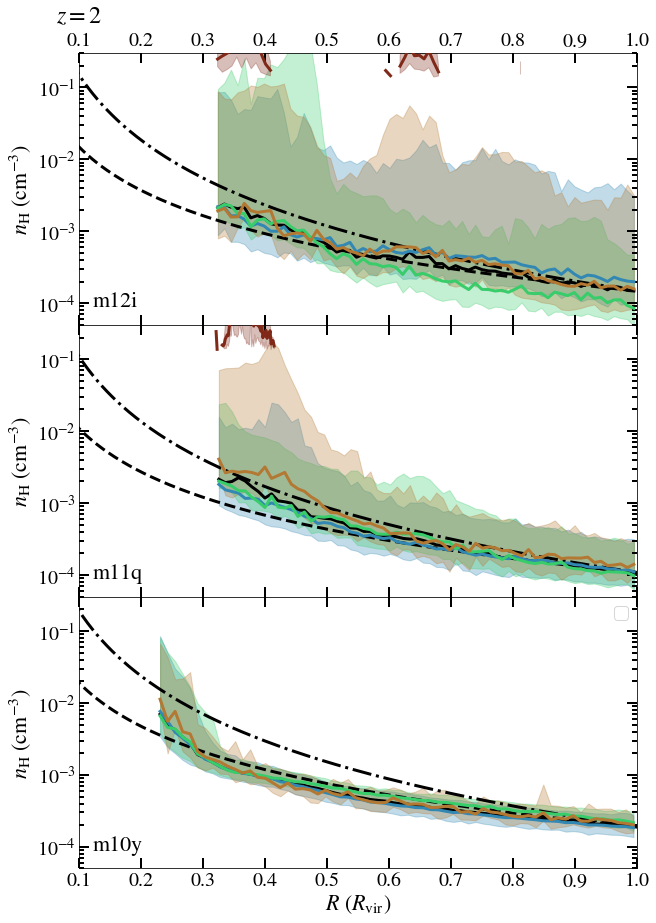

In [25]:
n_rows = len( mass_bins )

sim_names = [ 'm12i', 'm11q', 'm10y', ]

fig = plt.figure( figsize=(10,n_rows*5), facecolor='white' ) 
main_ax = plt.gca()

gs = gridspec.GridSpec( n_rows, 1 )

gs.update(wspace=0.025, hspace=0.0001)

handles, labels = [], []
for j, sim_name in enumerate( sim_names ):

    for i, classification in enumerate( classification_list ):    
        
        ax = plt.subplot(gs[j,0])

        radii_bin = radii[classification][sim_name]
        densities_bin = densities[classification][sim_name]
        volumes_bin = volumes[classification][sim_name]

        # Don't plot classifications when there are sims that have <100 particles
        # with that classification
        if radii_bin.size < 100:
            continue
            
        # Get an individual w_plotter out for easier labels
        w_plotter = w_set[sim_name]
        
        # Choose a different redshift for m12i to avoid a major merger
        if ( sim_name == 'm12i' ) and ( snum == 172 ):
            used_ind = 600 - 214 # Redshift 1.5
        else:
            used_ind = ind

        med, low_p, high_p, bin_edges = w_plotter.statistic_and_interval(
            'R',
            'HDen',
            statistic = 'weighted_mean',
            x_data = radii_bin,
            y_data = densities_bin,
            weights = volumes_bin,
            slices = used_ind,
            ax = ax,
            x_data_args = {
                'scale_key': 'Rvir',
                'scale_a_power': 1.,
                'scale_h_power': -1.,
            },
            plot_interval = classification != 'is_in_CGM',
            fix_invalid = True,
            zorder = 1000,
            classification = classification,
            color = p_constants.CLASSIFICATION_COLORS_B[classification],
            label = p_constants.CLASSIFICATION_LABELS[classification],
#             plot_label = r'$M_{\rm h}(z=0) \sim 10^{' + mass_bin[1:] + r'} M_\odot$',
            add_plot_label = ( i == 0 ),
            plot_label_kwargs = {
                'fontsize': 22,
                'xy': ( 0.025, 0.05, ),
#                 'xytext': ( 10., 10., ),
                'xycoords': 'axes fraction',
#                 'textcoords': 'offset points',
                'verticalalignment': 'bottom',
                'horizontalalignment': 'left',
            },
            return_values = True,
            alpha = 0.3,
            bins = 64,
        )

        # Limits and scale tweaking
        y_lims = {
            465: [ 2e-6, 1e-1 ],
            172: [ 5e-5, 3e-1 ],
        }
        ax.set_xlim( 0.1, 1. )
        ax.set_ylim( y_lims[snum] )
        ax.set_yscale( 'log' )

        # Labels
        ax.set_xlabel( r'$R$ $(R_{\rm vir})$', fontsize=22 )
        ax.set_ylabel( r'$n_{\rm H}$ (cm$^{-3}$)', fontsize=22, )
        
        # Hide some axis labels
        if not ax.is_last_row():
            ax.tick_params( labelbottom = False )
        if ax.is_first_row():
            ax.tick_params( labeltop = True )
            
        # Plot label
        if ax.is_first_row() and classification == 'is_in_CGM':
            ax.annotate(
                s = r'$z=' + '{:.02g}'.format( w.redshift.values[ind] ) + '$',
                xy = ( 0.0, 1.0 ),
                xytext = ( 0., 25., ),
                xycoords = 'axes fraction',
                textcoords = 'offset points',
                horizontalalignment = 'center',
                verticalalignment = 'bottom',
                fontsize = 24,
            )
            
        # Adjust tick parameters
        ax.tick_params( direction='in', which='both', top=True, right=True )
        
        # Plot a power law
        if classification == 'is_in_CGM':
            gammas = {
                465: [ -2, ],
                172: [ -2, -3, ],
            }
            linestyles = [ '--', '-.', ':' ] 
            for k, gamma in enumerate( gammas[snum] ):
                r_analytic = np.linspace( 0., 1., 256 )
                n_power = med[-1] * r_analytic ** gamma
                
                if gamma == -1:
                    continue

                ax.plot(
                    r_analytic,
                    n_power,
                    linewidth = 3,
                    color = 'k',
                    linestyle = linestyles[k],
                    label = ( r'$n_{\rm H} \propto R^{' + str(gamma) +r'}$'),
                )
        
        # Legend, including tweaking
        if classification == 'is_CGM_EP':
            # Reorder labels and preserve to slap them on the last plot
            handles, labels = ax.get_legend_handles_labels()
            for i, gamma in enumerate( gammas ):
                handles.append( handles[1] )
                labels.append( labels[1] )
                handles.remove( handles[1] )
                labels.remove( labels[1] )
        if ax.is_last_row():
            ax.legend(
                handles,
                labels,
                prop = { 'size': 18 },
#                 loc = 'upper right',
            )
            
# Save the File
save_file = 'CGM_den_profile_indiv_snum{}.pdf'.format( snum )
plotting.save_fig(
    out_dir = file_manager.get_project_figure_dir(),
    save_file = save_file,
    fig = fig,
)

# Metallicity Profile

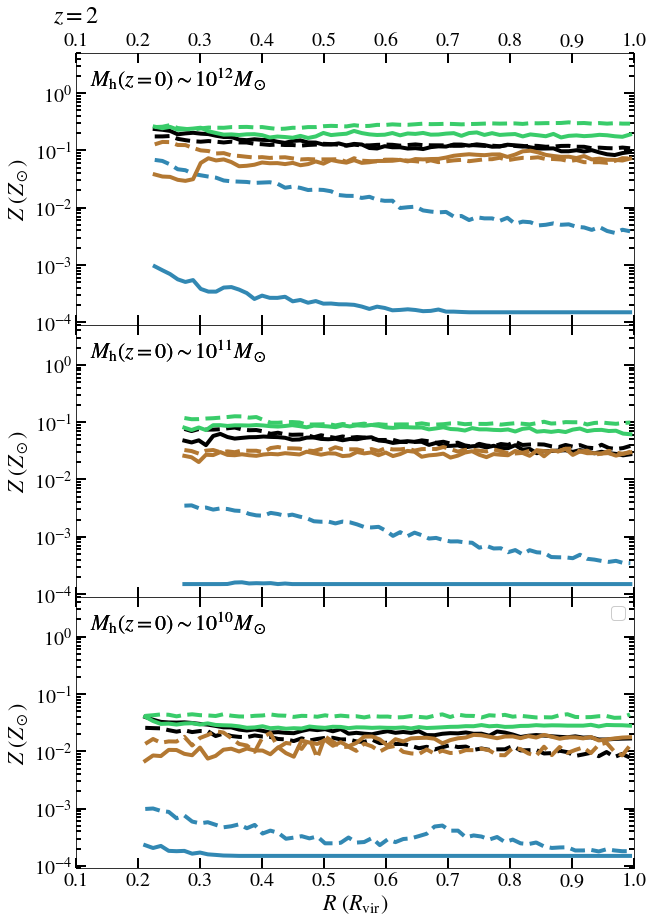

In [26]:
n_rows = len( mass_bins )

fig = plt.figure( figsize=(10,n_rows*5), facecolor='white' ) 
main_ax = plt.gca()

gs = gridspec.GridSpec( n_rows, 1 )

gs.update(wspace=0.025, hspace=0.0001)

handles, labels = [], []
for j, mass_bin in enumerate( mass_bins ):

    for i, classification in enumerate( classification_list ):    
        
        if classification == 'is_CGM_satellite_ISM':
            continue
        
        ax = plt.subplot(gs[j,0])

        radii_bin = radii[classification].split_by_dict( linefinder_config.MASS_BINS )[mass_bin]
        metallicities_bin = metallicities[classification].split_by_dict( linefinder_config.MASS_BINS )[mass_bin]
        
        radii_split = radii_bin.split_by_key_slice( slice(4,10), '_md' )
        metallicities_split = metallicities_bin.split_by_key_slice( slice(4,10), '_md' )
        
        for is_md in [ False, True ]:
            
            radii_bin = radii_split[is_md]
            metallicities_bin = metallicities_split[is_md]

            # Don't plot classifications when there are sims that have <100 particles
            # with that classification
            if radii_bin.size.array().min() < 100:
                continue

            linestyles = {
                False: '-',
                True: '--',
            }
            statistics = {
                True: 'mean',
                False: 'median',
            }
            med, low_p, high_p, bin_edges = w_plotter.statistic_and_interval(
                'R',
                'Z_asplund',
                statistic = statistics[classification=='is_in_CGM'],
                x_data = np.concatenate( radii_bin.array() ),
                y_data = np.concatenate( metallicities_bin.array() ),
                slices = ind,
                ax = ax,
                x_data_args = {
                    'scale_key': 'Rvir',
                    'scale_a_power': 1.,
                    'scale_h_power': -1.,
                },
#                 plot_interval = ( classification != 'is_in_CGM' ) and not is_md,
                plot_interval = False,
                fix_invalid = True,
                zorder = 1000,
                classification = classification,
                color = p_constants.CLASSIFICATION_COLORS_B[classification],
                label = p_constants.CLASSIFICATION_LABELS[classification],
                plot_label = r'$M_{\rm h}(z=0) \sim 10^{' + mass_bin[1:] + r'} M_\odot$',
                add_plot_label = ( i == 0 ),
                plot_label_kwargs = {
                    'fontsize': 22,
                    'xy': ( 0.025, 0.95, ),
                    'xycoords': 'axes fraction',
                    'verticalalignment': 'top',
                    'horizontalalignment': 'left',
                },
                return_values = True,
                bins = np.linspace( min_radii[mass_bin], 1., 64 ),
                alpha = 0.3,
                linewidth = 4,
                linestyle = linestyles[is_md],
            )

        # Limits and scale tweaking
        ax.set_xlim( 0.1, 1. )
        ax.set_ylim( 9e-5, 5. )
#         ax.set_xscale( 'log' )
        ax.set_yscale( 'log' )

        # Labels
        ax.set_xlabel( r'$R$ $(R_{\rm vir})$', fontsize=22 )
        ax.set_ylabel( r'$Z$ $(Z_\odot)$', fontsize=22, )
        
        # Hide some axis labels
        if not ax.is_last_row():
            ax.tick_params( labelbottom = False )
        if ax.is_first_row():
            ax.tick_params( labeltop = True )
            
        # Plot label
        if ax.is_first_row() and classification == 'is_in_CGM':
            ax.annotate(
                s = r'$z=' + '{:.02g}'.format( w.redshift.values[ind] ) + '$',
                xy = ( 0.0, 1.0 ),
                xytext = ( 0., 25., ),
                xycoords = 'axes fraction',
                textcoords = 'offset points',
                horizontalalignment = 'center',
                verticalalignment = 'bottom',
                fontsize = 24,
            )
            
        # Adjust tick parameters
        ax.tick_params( direction='in', which='both', top=True, right=True )
        
        # Legend, including tweaking
        if classification == 'is_CGM_EP':
            # Reorder labels and preserve to slap them on the last plot
            handles, labels = ax.get_legend_handles_labels()
            for i, gamma in enumerate( gammas ):
                handles.append( handles[1] )
                labels.append( labels[1] )
                handles.remove( handles[1] )
                labels.remove( labels[1] )
        if ax.is_last_row():
            loc = {
                465: None,
                172: 'upper left',
            }
            ax.legend(
                handles,
                labels,
                prop = { 'size': 18 },
#                 loc = loc[snum],
#                 ncol = ncol[snum],
                framealpha = 1.,
            )
            
# Save the File
save_file = 'CGM_met_profile_snum{}.pdf'.format( snum )
# plotting.save_fig(
#     out_dir = file_manager.get_project_figure_dir(),
#     save_file = save_file,
#     fig = fig,
# )

/opt/apps/intel17/python/2.7.13/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


File saved at /home1/03057/zhafen/papers/CGM_origin/figures/CGM_met_profile_snum172.pdf


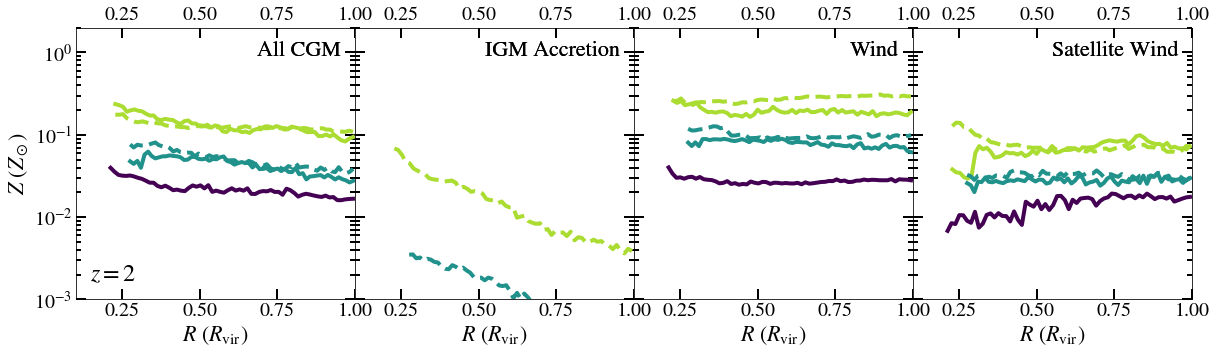

In [27]:
n_cols = 4

fig = plt.figure( figsize=(n_cols*5,5), facecolor='white' ) 
main_ax = plt.gca()

gs = gridspec.GridSpec( 1, n_cols )

gs.update(wspace=0.0001, hspace=0.00025)

met_data = verdict.Dict({})

bin_colors = {
    'm10': palettable.matplotlib.Viridis_9.mpl_colors[0],
    'm11': palettable.matplotlib.Viridis_9.mpl_colors[4],
    'm12': palettable.matplotlib.Viridis_9.mpl_colors[-2],
}
column_inds = {
    'is_in_CGM': 0,
    'is_CGM_IGM_accretion': 1,
    'is_CGM_wind': 2,
    'is_CGM_satellite_wind': 3,
}
handles, labels = [], []
for j, mass_bin in enumerate( mass_bins ):

    met_data[mass_bin] = verdict.Dict({})

    for i, classification in enumerate( classification_list ):
        
        if classification == 'is_CGM_satellite_ISM':
            continue
                            
        plot_classification = classification in column_inds.keys()
        if plot_classification:
            column_ind = column_inds[classification]

            ax = plt.subplot( gs[0,column_ind] )
        
        radii_bin = radii[classification].split_by_dict( linefinder_config.MASS_BINS )[mass_bin]
        metallicities_bin = metallicities[classification].split_by_dict( linefinder_config.MASS_BINS )[mass_bin]
        
        radii_split = radii_bin.split_by_key_slice( slice(4,10), '_md' )
        metallicities_split = metallicities_bin.split_by_key_slice( slice(4,10), '_md' )
        
        for is_md in [ False, True ]:
                        
            # Skip this bin, for which we only have one simulation
            if is_md and mass_bin == 'm10':
                continue
            
            radii_bin = radii_split[is_md]
            metallicities_bin = metallicities_split[is_md]

            # Don't plot classifications when there are sims that have <100 particles
            # with that classification
            if radii_bin.size.array().min() < 100:
                continue

            linestyles = {
                False: '-',
                True: '--',
            }
            statistics = {
                True: 'mean',
                False: 'median',
            }
            line_label = {
                True: r'$M_{\rm h}(z=0) \sim 10^{' + mass_bin[1:] + r'} M_\odot$',
                False: None,
            }
            med, low_p, high_p, bin_edges = w_plotter.statistic_and_interval(
                'R',
                'Z_asplund',
                statistic = statistics[classification=='is_in_CGM'],
                x_data = np.concatenate( radii_bin.array() ),
                y_data = np.concatenate( metallicities_bin.array() ),
                slices = ind,
                ax = ax,
                x_data_args = {
                    'scale_key': 'Rvir',
                    'scale_a_power': 1.,
                    'scale_h_power': -1.,
                },
#                 plot_interval = ( classification != 'is_in_CGM' ) and not is_md,
                plot_interval = False,
                fix_invalid = True,
                zorder = 1000,
                classification = classification,
                color = bin_colors[mass_bin],
                label = line_label[( not is_md ) and snum==465],
                plot_label = p_constants.CLASSIFICATION_LABELS[classification],
                add_plot_label = ( j == 0 ),
                plot_label_kwargs = {
                    'fontsize': 22,
                    'xy': ( 0.95, 0.95, ),
                    'xycoords': 'axes fraction',
                    'verticalalignment': 'top',
                    'horizontalalignment': 'right',
                },
                return_values = True,
                bins = np.linspace( min_radii[mass_bin], 1., 64 ),
                alpha = 0.3,
                linewidth = 4,
                linestyle = linestyles[is_md],
            )
            
            # Store data
            labels = {
                True: 'md',
                False: 'non_md',
            }
            try:
                met_data[mass_bin][classification][labels[is_md]] = verdict.Dict({})
            except KeyError:
                met_data[mass_bin][classification] = verdict.Dict({})
                met_data[mass_bin][classification][labels[is_md]] = verdict.Dict({})
            met_data[mass_bin][classification][labels[is_md]][statistics[is_md]] = med
            met_data[mass_bin][classification][labels[is_md]]['16th_percentile'] = low_p
            met_data[mass_bin][classification][labels[is_md]]['84th_percentile'] = high_p
            x_values = bin_edges[:-1] + 0.5 * ( bin_edges[1] - bin_edges[0] )
            met_data[mass_bin][classification][labels[is_md]]['x_values'] = x_values
            
        # Limits and scale tweaking
        ax.set_xlim( 0.1, 1. )
        ax.set_ylim( 1e-3, 2.0 )
#         ax.set_xscale( 'log' )
        ax.set_yscale( 'log' )

        # Labels
        if snum == 172:
            ax.set_xlabel( r'$R$ $(R_{\rm vir})$', fontsize=22 )
        if ax.is_first_col():
            ax.set_ylabel( r'$Z$ $(Z_\odot)$', fontsize=22, )
        
        # Hide some axis labels
        if snum != 172:
            ax.tick_params( labelbottom = False )
        if ax.is_first_row():
            ax.tick_params( labeltop = True )
            
        # Plot label
        if ax.is_first_col() and mass_bin=='m12':
            ax.annotate(
                s = r'$z=' + '{:.02g}'.format( w.redshift.values[ind] ) + '$',
                xy = ( 0.05, 0.05 ),
                xytext = ( 0., 0., ),
                xycoords = 'axes fraction',
                textcoords = 'offset points',
                horizontalalignment = 'left',
                verticalalignment = 'bottom',
                fontsize = 24,
            )
            
        # Hide ticks
        if not ax.is_first_col():
            ax.tick_params( labelleft = False )
            
        # Adjust tick parameters
        ax.tick_params( direction='in', which='both', top=True, right=True )
        
        # Legend, including tweaking
#         if classification == 'is_CGM_EP':
#             # Reorder labels and preserve to slap them on the last plot
#             handles, labels = ax.get_legend_handles_labels()
#             for i, gamma in enumerate( gammas ):
#                 handles.append( handles[1] )
#                 labels.append( labels[1] )
#                 handles.remove( handles[1] )
#                 labels.remove( labels[1] )
        if classification=='is_CGM_wind':
            loc = {
                465: None,
                172: 'upper left',
            }
            ax.legend(
#                 handles,
#                 labels,
                prop = { 'size': 18 },
#                 loc = loc[snum],
#                 ncol = ncol[snum],
                framealpha = 1.,
            )
            
# Save the File
save_file = 'CGM_met_profile_snum{}.pdf'.format( snum )
plotting.save_fig(
    out_dir = file_manager.get_project_figure_dir(),
    save_file = save_file,
    fig = fig,
)

all_data['metallicity'] = met_data

File saved at /work/03057/zhafen/extra_plots/CGM_origin/CGM_met_profile_v2_snum172.pdf


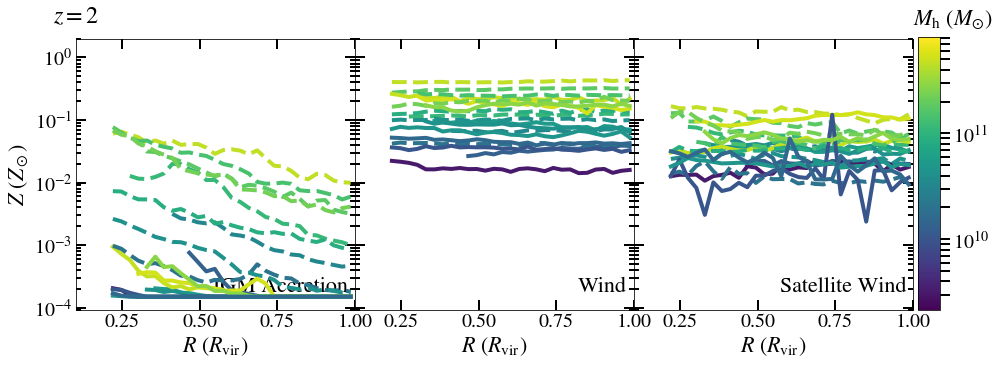

In [28]:
n_cols = 3

fig = plt.figure( figsize=(n_cols*5,5), facecolor='white' ) 
main_ax = plt.gca()

z_min = halo_masses.array().min()/1.5
z_max = halo_masses.array().max()*1.5

gs = gridspec.GridSpec( 1, n_cols )

gs.update(wspace=0.0001, hspace=0.00025)

met_profiles = verdict.Dict( {} )

column_inds = {
    'is_CGM_IGM_accretion': 0,
    'is_CGM_wind': 1,
    'is_CGM_satellite_wind': 2,
}
for i, classification in enumerate( classification_list ):
    
    met_profiles[classification] = verdict.Dict( {} )
    
    plot_classification = classification in column_inds.keys()
    if plot_classification:
        column_ind = column_inds[classification]

        ax = plt.subplot( gs[0,column_ind] )
    
    for j, ( sim_name, w_plotter ) in enumerate( w_set.items() ):
        
        # Don't plot classifications when there are sims that have <100 particles
        # with that classification
        radii_bin = radii[classification].split_by_dict( linefinder_config.MASS_BINS )
        if radii_bin[linefinder_config.MASS_BINS[sim_name]].size.array().min() < 100:
            continue
        
        if sim_name == 'm10q':
            continue
        
        w = w_plotter.data_object
        w.retrieve_halo_data()
        m_vir = w.m_vir.values[ind]

        z_width = np.log10( z_max ) - np.log10( z_min )
        color_value = ( np.log10( m_vir ) - np.log10( z_min ) )/z_width
        color = cm.viridis( color_value )
        
        if sim_name[-3:] == '_md':
            linestyle = '--'
        else:
            linestyle = '-'
        
        statistics = {
            True: 'mean',
            False: 'median',
        }
        med, low_p, high_p, bin_edges = w_plotter.statistic_and_interval(
            'R',
            'Z_asplund',
            statistic = statistics[classification=='is_in_CGM'],
            x_data = radii[classification][sim_name],
            y_data = metallicities[classification][sim_name],
            slices = ind,
            ax = ax,
            x_data_args = {
                'scale_key': 'Rvir',
                'scale_a_power': 1.,
                'scale_h_power': -1.,
            },
            skip_plot = not plot_classification,
            plot_interval = False,
            fix_invalid = True,
            zorder = 1000,
            classification = classification,
            color = color,
            plot_label = p_constants.CLASSIFICATION_LABELS[classification],
            add_plot_label = j == 0,
            plot_label_kwargs = {
                'fontsize': 22,
                'xy': ( 0.975, 0.05, ),
                'xycoords': 'axes fraction',
                'verticalalignment': 'bottom',
                'horizontalalignment': 'right',
            },
            return_values = True,
            bins = np.linspace( min_radii[mass_bin], 1., 30 ),
            alpha = 0.3,
            linewidth = 4,
            linestyle = linestyle,
        )
        
        met_profiles[classification][sim_name] = med
    
    # Labels
    ax.set_xlabel( r'$R$ $(R_{\rm vir})$', fontsize=22 )
    if ax.is_first_col():
        ax.set_ylabel( r'$Z$ $(Z_\odot)$', fontsize=22, )
        
        # Plot label
    if ax.is_first_col():
        ax.annotate(
            s = r'$z=' + '{:.02g}'.format( w.redshift.values[ind] ) + '$',
            xy = ( 0.0, 1.0 ),
            xytext = ( 0., 10., ),
            xycoords = 'axes fraction',
            textcoords = 'offset points',
            horizontalalignment = 'center',
            verticalalignment = 'bottom',
            fontsize = 24,
        )
        
    # Limits and scale
    ax.set_xlim( 0.1, 1. )
    ax.set_ylim( 9e-5, 2. )
    ax.set_yscale( 'log' )
    
    # Hide ticks
    if not ax.is_first_col():
        ax.tick_params( labelleft = False )
        
    # Modify tick parameters
    ax.tick_params( direction='in', which='both', top=True, right=True )
    
# Add a colorbar
sm = cm.ScalarMappable(
    cmap = cm.viridis,
    norm=colors.LogNorm( z_min, z_max ),
)
sm._A = []
plotting.add_colorbar(
    fig,
    sm,
    method='fig',
    ax_location=[0.905, 0.125, 0.02, 0.76]
)

plt.subplot( gs[0,-1] ).annotate(
    s = r'$M_{\rm h}$ $(M_{\odot})$',
    xy = (1., 1.05),
    xycoords = 'axes fraction',
    fontsize = 22,
)

# Save the File
save_file = 'CGM_met_profile_v2_snum{}.pdf'.format( snum )
plotting.save_fig(
    out_dir = file_manager.project_parameters['extras_dir'],
    save_file = save_file,
    fig = fig,
)

# Save Data

In [29]:
all_data.to_hdf5(
    '../data/radial_profiles_snum{}.hdf5'.format( snum ),
    attributes = {
        'redshift': w_set['m12i'].redshift[snum],
    },
)

Attribute redshift not found in plotting object. Checking data object.


# Plot Mass Fraction at Given Radii

In [30]:
# Get the masses per radii
masses_per_radii = {}
radii_bins = {}
for i, classification in enumerate( classification_list ):
    masses_per_radii[classification] = {}
    for sim_name, sim_radii in radii[classification].items():
        
        # Choose the bins (and store them for later use)
        mass_bin = linefinder_config.MASS_BINS[sim_name]
        used_radii_bins = np.linspace( min_radii[mass_bin], 1., 50 )
        radii_bins[mass_bin] = used_radii_bins
        
        masses_per_radii[classification][sim_name] = np.histogram(
            sim_radii,
            bins = used_radii_bins,
            weights = masses[classification][sim_name],
            density = False,
        )[0]    
masses_per_radii = verdict.Dict( masses_per_radii )

In [31]:
# Split the masses per radii in all CGM for easier handling later
mass_per_radii_all_CGM = masses_per_radii['is_in_CGM'].split_by_dict( linefinder_config.MASS_BINS )

In [32]:
min_values_per_bin = (
    ( masses_per_radii.sum_contents() - masses_per_radii['is_in_CGM'] ) /
    masses_per_radii['is_in_CGM']
).apply( np.nanmin )

min_sim, min_value = min_values_per_bin.keymin()

assert min_value > 0.95, "More than 5% of mass not classified!"

/home1/03057/zhafen/repos/verdict/verdict.py:269: RuntimeWarning: invalid value encountered in divide
  results[key] = self._storage[key]/other[key]


File saved at /home1/03057/zhafen/papers/CGM_origin/figures/CGM_fraction_profile_snum172.pdf


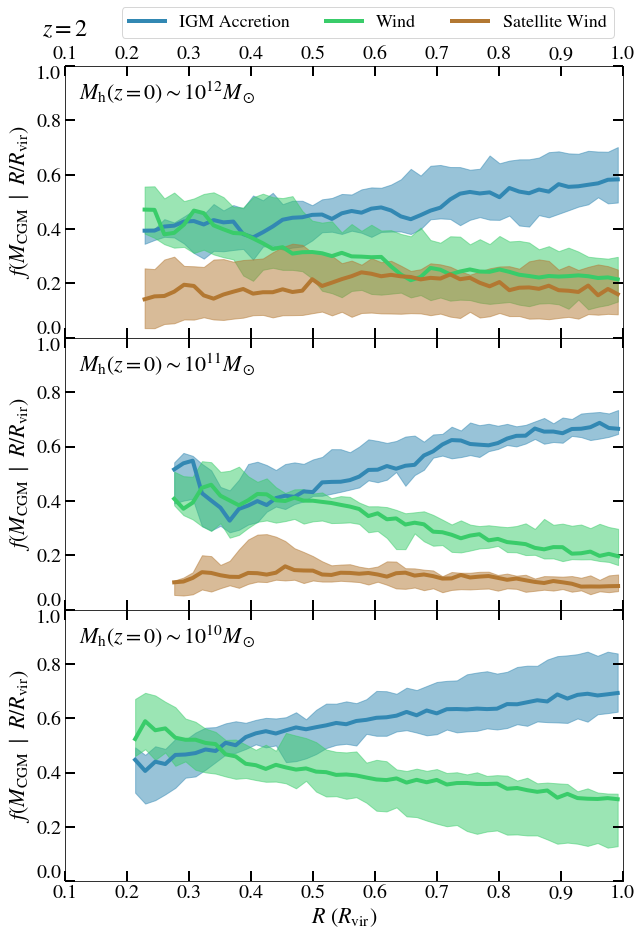

In [33]:
n_rows = len( mass_bins )

fig = plt.figure( figsize=(10,n_rows*5), facecolor='white' ) 
main_ax = plt.gca()

gs = gridspec.GridSpec( n_rows, 1 )

gs.update(wspace=0.025, hspace=0.0001)

handles, labels = [], []
for j, mass_bin in enumerate( mass_bins ):

    for i, classification in enumerate( classification_list ):
        
        # No sense plotting this, because it should be all at 1
        if classification == 'is_in_CGM':
            continue
        
        ax = plt.subplot(gs[j,0])
        
        # Don't plot classifications when there are sims that have <100 particles
        # with that classification
        radii_bin = radii[classification].split_by_dict( linefinder_config.MASS_BINS )[mass_bin]
        if radii_bin.size.array().min() < 1000:
            continue

        # Get raw data
        mass_per_radii_bin = masses_per_radii[classification].split_by_dict( linefinder_config.MASS_BINS )[mass_bin]
        tot_mass_per_radii_bin = mass_per_radii_all_CGM[mass_bin]
        mass_frac_per_radii_bin = mass_per_radii_bin / tot_mass_per_radii_bin
                
        # Get median and percentiles
        med_mass_frac_per_radii_bin = np.nanmedian( mass_frac_per_radii_bin.array(), axis=0 )
        plow_mass_frac_per_radii_bin = np.nanpercentile( 
            mass_frac_per_radii_bin.array(), 
            axis = 0,
            q = 16,
        )
        phigh_mass_frac_per_radii_bin = np.nanpercentile( 
            mass_frac_per_radii_bin.array(), 
            axis = 0,
            q = 84,
        )
        
        # Set up x values
        radii_bin = radii_bins[mass_bin]
        radii_bin_centers = ( radii_bin + 0.5 * ( radii_bin[1] - radii_bin[0] ) )[:-1]
        
        # Plot median
        ax.plot(
            radii_bin_centers,
            med_mass_frac_per_radii_bin,
            linewidth = 4,
            color = p_constants.CLASSIFICATION_COLORS_B[classification],
            label = p_constants.CLASSIFICATION_LABELS[classification],
        )
        
        # Plot intervals
        ax.fill_between(
            radii_bin_centers,
            plow_mass_frac_per_radii_bin,
            phigh_mass_frac_per_radii_bin,
            alpha = 0.5,
            color = p_constants.CLASSIFICATION_COLORS_B[classification],
        )

        # Limits and scale tweaking
        ax.set_xlim( 0.1, 1. )
        ax.set_ylim( 0.0, 1. )

        # Labels
        ax.set_xlabel( r'$R$ $(R_{\rm vir})$', fontsize=22 )
        ax.set_ylabel( r'$f(M_{\rm CGM}$ $\mid$ $R / R_{\rm vir})$', fontsize=22, )
        
        # Hide some axis labels
        if not ax.is_last_row():
            ax.tick_params( labelbottom = False )
        if ax.is_first_row():
            ax.tick_params( labeltop = True )
            
    # Plot label
    if ax.is_first_row():
        ax.annotate(
            s = r'$z=' + '{:.02g}'.format( w.redshift.values[ind] ) + '$',
            xy = ( 0.0, 1.0 ),
            xytext = ( 0., 25., ),
            xycoords = 'axes fraction',
            textcoords = 'offset points',
            horizontalalignment = 'center',
            verticalalignment = 'bottom',
            fontsize = 24,
        )
    # Bin labels
    ax.annotate(
        s = r'$M_{\rm h}(z=0) \sim 10^{' + mass_bin[1:] + r'} M_\odot$',
        xy = ( 0.025, 0.95 ),
        xycoords = 'axes fraction',
        horizontalalignment = 'left',
        verticalalignment = 'top',
        fontsize = 22, 
    )

    # Avoid overlapping ticks
    ax.get_yticklabels()[0].set_verticalalignment( 'bottom' )
    ax.get_yticklabels()[-1].set_verticalalignment( 'top' )

    # Adjust tick parameters
    ax.tick_params( direction='in', which='both', top=True, right=True )

    if ax.is_first_row():
        ax.legend(
            prop = { 'size': 18 },
            loc = 'lower right',
            bbox_to_anchor = ( 1.0, 1.07 ),
            ncol = 3,
        )
            
# Save the File
save_file = 'CGM_fraction_profile_snum{}.pdf'.format( snum )
plotting.save_fig(
    out_dir = file_manager.get_project_figure_dir(),
    save_file = save_file,
    fig = fig,
)

# Plot Radial Distributions

In [34]:
classification_list = copy.copy( p_constants.CLASSIFICATIONS_CGM_ORIGIN )
classification_list.remove( 'is_CGM_satellite_ISM' )
classification_list.insert( 0, 'is_in_CGM' )

In [35]:
w_set.data_object.retrieve_halo_data()
halo_masses = w_set.data_object.m_vir.inner_item( snum )

In [ ]:
cooling_flow_data = np.load( './coolingflow_Mhalo_12.0.npz' )

In [ ]:
hists = {}

base_bins = np.linspace( 0.1, 1.0, 256 )
for version in [ 2 ]:
    
    fig = plt.figure( figsize=(10,16), facecolor='white' )
    main_ax = plt.gca()

    z_min = halo_masses.array().min()/1.5
    z_max = halo_masses.array().max()*1.5

    gs = matplotlib.gridspec.GridSpec( len( classification_list ), 1, )

    gs.update(wspace=0.025, hspace=0.0001)

    # Start from a fresh slate
    w_set.data_object.data_masker.clear_masks( True )
    # Choose only gas
    w_set.data_object.data_masker.mask_data( 'PType', data_value=linefinder_config.PTYPE_GAS )

    for i, classification in enumerate( classification_list ):

        hists[classification] = verdict.Dict( {} )

        ax = plt.subplot( gs[i,0] )

        y_max = 0
        for sim_name, w_plotter in w_set.items():
            
            print( sim_name )

            # Plot only some simulations
            if version == 1:
                if sim_name not in [ 'm10y', 'm11v', 'm12i', ]:
                    continue
            elif version == 2:
                # Skip the outlier
                if sim_name == 'm10z':
                    continue

            # Get the data
            w = w_plotter.data_object
            w.retrieve_halo_data()
            m_vir = w.m_vir.values[ind]
            r_vir = w.r_vir.values[ind]

            # Only plot when there's enough data
            n_class = w.get_selected_data( classification, sl=(slice(None),ind), ).sum()
            if n_class < 1000:
                print( 'Insufficient {} for sim {}'.format( classification, sim_name ) )
                continue

            # Get length scales
            length_scale = w.halo_data.get_mt_data(
                w.galids.parameters['length_scale'],
                a_power=1.,
                snums=[ snum, ]
            )[0]/w.hubble_param
            r_gal = length_scale * w.galids.parameters['galaxy_cut']
            r_cgm_inner = r_gal * ( 1. + linefinder_config.F_GAP )

            # Color
            z_width = np.log10( z_max ) - np.log10( z_min )
            color_value = ( np.log10( m_vir ) - np.log10( z_min ) )/z_width
            color = cm.viridis( color_value )

            # Set up consistent bins across simulations
            used_bins = base_bins[r_cgm_inner/r_vir < base_bins]
#             used_bins = base_bins[min_radii[linefinder_config.MASS_BINS[sim_name]] < base_bins]
            
            hist, edges = w_plotter.histogram(
                'R',
                weight_key = 'M',
                ax = ax,
                mask_zeros = True,
    #             norm_type = 'bin_width',
                norm_type = 'probability',
    #             scaling = w.conversion_factor,
                smooth = True,
                smoothing_window_length = 31,
                histogram_style = 'line',
                x_label = r'$R/R_{\rm vir}$',
                y_label = p_constants.CLASSIFICATION_LABELS[classification],
                bins = used_bins,
                slices = ind,
                plot_label = None,
                color = color,
                assert_contains_all_data = False,
                classification = classification,
                data_kwargs = {
                    'scale_key' : 'Rvir',
                    'scale_a_power' : 1.,
                    'scale_h_power' : -1.,
                },
                return_dist = True,
            )
            
            # Plot the Cooling flow model
            ax.plot(
                cooling_flow_data['R2Rvir'],
                cooling_flow_data['dMdR'],
            )

            # Track the maxes so we can set plot limits
            if hist.max() > y_max:
                y_max = hist.max()
                
            # Store the data
            if version == 2:
                hist_to_store = np.ones( base_bins.shape ) * np.nan
                hist_to_store[-hist.size:] = hist
                hists[classification][sim_name] = hist_to_store

        if snum == 172:
            x_min = 0.24
        elif snum == 465:
            x_min = 0.1
        ax.set_xlim( x_min, 1. )
        ax.set_ylim( 0., y_max, )
        ax.set_yscale( 'linear' )

        # Adjust tick parameters
        ax.tick_params( direction='inout', which='both', top=True, )

        # Rotate labels
    #     ax.yaxis.label.set_rotation( 'horizontal' )
    #     ax.yaxis.label.set_color(
    #         p_constants.CLASSIFICATION_COLORS_B[classification]
    #     )

        if classification != 'is_in_CGM':
            ax.yaxis.label.set_path_effects(
                [
                    path_effects.Stroke(
                        linewidth=2,
                        foreground=p_constants.CLASSIFICATION_COLORS_B[classification]
        #                 foreground='k',
                    ),
                    path_effects.Normal() 
                ]
            )

        # Add another x-axis label
        if i == 0:

            ax.annotate(
                s = r'$R/R_{\rm vir}$',
                xy = ( 0.5, 1.17, ),
                xycoords = 'axes fraction',
                fontsize = 22,
                ha = 'center',
            )

        # Add a label to the y axes
        if i == 0:

            formatted_redshift = '{:.02g}'.format( w.redshift.values[ind] )

            ax.annotate(
                s = r'$\frac{d(M/M_{\rm tot})}{d(r/r_{\rm vir})}' + r'(z={})$'.format( formatted_redshift ),
                xy = ( 0, 1.2, ),
                xycoords = 'axes fraction',
                fontsize = 28,
                ha = 'center',
            )

        # Hide labels
        if i != len( classification_list ) - 1:
            ax.tick_params( labelbottom = False )
        if i == 0:
            ax.tick_params( labeltop = True )

        # Avoid overlapping ticks
        ax.get_yticklabels()[0].set_verticalalignment( 'bottom' )
        ax.get_yticklabels()[-1].set_verticalalignment( 'top' )
    #     ax.set_yticklabels([0., 0.5, 1. ], va='top' )

    # Add a colorbar
    sm = cm.ScalarMappable(
        cmap = cm.viridis,
        norm=colors.LogNorm( z_min, z_max ),
    )
    sm._A = []
    plotting.add_colorbar(
        fig,
        sm,
        method = 'fig',
        ax_location = [ 0.905, 0.125, 0.03, 0.76 ]
    )
    plt.subplot( gs[0,0] ).annotate(
        s = r'$M_{\rm h}$ $(M_{\odot})$',
        xy = (1., 1.2),
    #     xy = (1.15, 0.5),
        xycoords = 'axes fraction',
        fontsize = 22,
        ha = 'center',
    )

    if version == 1:
        save_file = 'CGM_profile_snum{}.pdf'.format( snum )

        plotting.save_fig(
            out_dir = file_manager.get_project_figure_dir(),
            save_file = save_file,
            fig = fig,
        )

m12b_md
Plotting histogram for R


/opt/apps/intel17/python/2.7.13/lib/python2.7/site-packages/scipy-0.19.0-py2.7-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


m10q
Plotting histogram for R
m11e_md
Plotting histogram for R
m10z
m12z_md
Plotting histogram for R
m11v
Plotting histogram for R
m11q
Plotting histogram for R
m10y
Plotting histogram for R
m12r_md
Plotting histogram for R
m12f
Plotting histogram for R


## Plot Aggregate

In [ ]:
medians = {}

fig = plt.figure( figsize=(10,16), facecolor='white' )
main_ax = plt.gca()

gs = matplotlib.gridspec.GridSpec( len( classification_list ), 1, )

gs.update(wspace=0.025, hspace=0.0001)

for i, classification in enumerate( classification_list ):
    
    medians[classification] = verdict.Dict( {} )
    
    y_max = 0
    
    class_hists = hists[classification]
    
#     plotted_colors = [ '#36a936', '#3636a9', '#a93636' ]
    plotted_colors = [ '#2820c6', '#0aa929', '#dfb707' ]
#     plotted_colors = [ qual_colormaps.DARK2[j] for j in range(3) ]
                
    valid_regime = np.invert( np.isnan( class_hists.array() ) ).sum( axis=0 ) >= 2

    used_bins = base_bins[valid_regime]
    sub_arr = class_hists.array()[slice(None),valid_regime]

    ax = plt.subplot( gs[i,0] )

    median = np.nanmedian( sub_arr, axis=0 )
    ax.plot(
        used_bins,
        median,
        color = 'k',
        linewidth = 3,
    )

    ax.fill_between(
        used_bins,
        np.nanmin( sub_arr, axis=0 ),
        np.nanmax( sub_arr, axis=0 ),
        color = 'k',
        alpha = 0.4,
    )

    ax.fill_between(
        used_bins,
        np.nanpercentile( sub_arr, 25, axis=0 ),
        np.nanpercentile( sub_arr, 75, axis=0 ),
#         np.nanpercentile( sub_arr, 50 - 68/2, axis=0 ),
#         np.nanpercentile( sub_arr, 50 + 68/2, axis=0 ),        
        color = 'k',
        alpha = 0.4,
    )

    # Track the maxes so we can set plot limits
    hist_max = np.nanmax( class_hists.array() )

    if hist_max > y_max:
        y_max = hist_max
      
    ax.set_xlabel(
        r'$R/R_{\rm vir}$',
        fontsize = 22,
    )
    ax.set_ylabel(
        p_constants.CLASSIFICATION_LABELS[classification],
        fontsize = 22,
    )
     
    if snum == 172:
        x_min = 0.24
    elif snum == 465:
        x_min = 0.1
    ax.set_xlim( x_min, 1. )
    ax.set_ylim( 0., y_max, )
    ax.set_yscale( 'linear' )

    # Adjust tick parameters
    ax.tick_params( direction='inout', which='both', top=True, )

    # Rotate labels
#     ax.yaxis.label.set_rotation( 'horizontal' )
#     ax.yaxis.label.set_color(
#         p_constants.CLASSIFICATION_COLORS_B[classification]
#     )

    if classification != 'is_in_CGM':
        ax.yaxis.label.set_path_effects(
            [
                path_effects.Stroke(
                    linewidth=2,
                    foreground=p_constants.CLASSIFICATION_COLORS_B[classification]
    #                 foreground='k',
                ),
                path_effects.Normal() 
            ]
        )

    # Add another x-axis label
    if i == 0:

        ax.annotate(
            s = r'$R/R_{\rm vir}$',
            xy = ( 0.5, 1.17, ),
            xycoords = 'axes fraction',
            fontsize = 22,
            ha = 'center',
        )
        
    if i == 2:
        ax.legend(
            prop={'size': 18},
            loc = 'upper right',
        )

    # Add a label to the y axes
    if i == 0:

        formatted_redshift = '{:.02g}'.format( w.redshift.values[ind] )

        ax.annotate(
            s = r'$\frac{d(M/M_{\rm origin})}{d(R/R_{\rm vir})}' + r'(z={})$'.format( formatted_redshift ),
            xy = ( 0, 1.2, ),
            xycoords = 'axes fraction',
            fontsize = 28,
            ha = 'center',
        )

    # Hide labels
    if i != len( classification_list ) - 1:
        ax.tick_params( labelbottom = False )
    if i == 0:
        ax.tick_params( labeltop = True )

    # Avoid overlapping ticks
    ax.get_yticklabels()[0].set_verticalalignment( 'bottom' )
    ax.get_yticklabels()[-1].set_verticalalignment( 'top' )
#     ax.set_yticklabels([0., 0.5, 1. ], va='top' )

save_file = 'CGM_aggregate_profile_snum{}.pdf'.format( snum )
plotting.save_fig(
    out_dir = file_manager.get_project_figure_dir(),
    save_file = save_file,
    fig = fig,
)

### Plot only m12s in order to compare to the cooling flow model

In [ ]:
len( hists[classification].split_by_dict( linefinder_config.MASS_BINS )['m12'].keys() )

In [ ]:
medians = {}

fig = plt.figure( figsize=(10,16), facecolor='white' )
main_ax = plt.gca()

gs = matplotlib.gridspec.GridSpec( len( classification_list ), 1, )

gs.update(wspace=0.025, hspace=0.0001)

for i, classification in enumerate( classification_list ):
    
    medians[classification] = verdict.Dict( {} )
    
    y_max = 0
    
    class_hists = hists[classification].split_by_dict( linefinder_config.MASS_BINS )['m12']
    
#     plotted_colors = [ '#36a936', '#3636a9', '#a93636' ]
    plotted_colors = [ '#2820c6', '#0aa929', '#dfb707' ]
#     plotted_colors = [ qual_colormaps.DARK2[j] for j in range(3) ]
                
    valid_regime = np.invert( np.isnan( class_hists.array() ) ).sum( axis=0 ) >= 2

    used_bins = base_bins[valid_regime]
    sub_arr = class_hists.array()[slice(None),valid_regime]

    ax = plt.subplot( gs[i,0] )

    median = np.nanmedian( sub_arr, axis=0 )
    ax.plot(
        used_bins,
        median,
        color = 'k',
        linewidth = 3,
    )

    ax.fill_between(
        used_bins,
        np.nanmin( sub_arr, axis=0 ),
        np.nanmax( sub_arr, axis=0 ),
        color = 'k',
        alpha = 0.2,
    )

    ax.fill_between(
        used_bins,
        np.nanpercentile( sub_arr, 25, axis=0 ),
        np.nanpercentile( sub_arr, 75, axis=0 ),
#         np.nanpercentile( sub_arr, 50 - 68/2, axis=0 ),
#         np.nanpercentile( sub_arr, 50 + 68/2, axis=0 ),        
        color = 'k',
        alpha = 0.3,
    )
    
    # Plot the cooling flow model
    ax.plot(
        cooling_flow_data['R2Rvir'],
        cooling_flow_data['dMdR'],
        linewidth = 3,
        color = 'k',
        linestyle = '--',
    )

    # Track the maxes so we can set plot limits
    hist_max = np.nanmax( class_hists.array() )

    if hist_max > y_max:
        y_max = hist_max
      
    ax.set_xlabel(
        r'$R/R_{\rm vir}$',
        fontsize = 22,
    )
    ax.set_ylabel(
        p_constants.CLASSIFICATION_LABELS[classification],
        fontsize = 22,
    )
     
    if snum == 172:
        x_min = 0.24
    elif snum == 465:
        x_min = 0.1
    ax.set_xlim( x_min, 1. )
    ax.set_ylim( 0., 2.5, )
    ax.set_yscale( 'linear' )

    # Adjust tick parameters
    ax.tick_params( direction='inout', which='both', top=True, )

    # Rotate labels
#     ax.yaxis.label.set_rotation( 'horizontal' )
#     ax.yaxis.label.set_color(
#         p_constants.CLASSIFICATION_COLORS_B[classification]
#     )

    if classification != 'is_in_CGM':
        ax.yaxis.label.set_path_effects(
            [
                path_effects.Stroke(
                    linewidth=2,
                    foreground=p_constants.CLASSIFICATION_COLORS_B[classification]
    #                 foreground='k',
                ),
                path_effects.Normal() 
            ]
        )

    # Add another x-axis label
    if i == 0:

        ax.annotate(
            s = r'$R/R_{\rm vir}$',
            xy = ( 0.5, 1.17, ),
            xycoords = 'axes fraction',
            fontsize = 22,
            ha = 'center',
        )
        
    if i == 2:
        ax.legend(
            prop={'size': 18},
            loc = 'upper right',
        )

    # Add a label to the y axes
    if i == 0:

        formatted_redshift = '{:.02g}'.format( w.redshift.values[ind] )

        ax.annotate(
            s = r'$\frac{d(M/M_{\rm origin})}{d(R/R_{\rm vir})}' + r'(z={})$'.format( formatted_redshift ),
            xy = ( 0, 1.2, ),
            xycoords = 'axes fraction',
            fontsize = 28,
            ha = 'center',
        )

    # Hide labels
    if i != len( classification_list ) - 1:
        ax.tick_params( labelbottom = False )
    if i == 0:
        ax.tick_params( labeltop = True )

    # Avoid overlapping ticks
    ax.get_yticklabels()[0].set_verticalalignment( 'bottom' )
    ax.get_yticklabels()[-1].set_verticalalignment( 'top' )
#     ax.set_yticklabels([0., 0.5, 1. ], va='top' )

save_file = 'CGM_aggregate_profile_m12s_snum{}.pdf'.format( snum )
plotting.save_fig(
    out_dir = file_manager.get_project_figure_dir(),
    save_file = save_file,
    fig = fig,
)

## Plot all

In [ ]:
medians = {}

fig = plt.figure( figsize=(10,16), facecolor='white' )
main_ax = plt.gca()

gs = matplotlib.gridspec.GridSpec( len( classification_list ), 1, )

gs.update(wspace=0.025, hspace=0.0001)

for i, classification in enumerate( classification_list ):
    
    medians[classification] = verdict.Dict( {} )
    
    y_max = 0
    
    sub_hists = hists[classification].split_by_dict( linefinder_config.MASS_BINS )
    
#     plotted_colors = [ '#36a936', '#3636a9', '#a93636' ]
#     plotted_colors = [ '#2820c6', '#0aa929', '#dfb707' ]
#     plotted_colors = [ qual_colormaps.DARK2[j] for j in range(3) ]
    plotted_colors = palettable.matplotlib.Viridis_3.mpl_colors
#     plotted_colors = palettable.cartocolors.qualitative.Safe_3.mpl_colors
    for mass_bin, color in zip( [ 'm10', 'm11', 'm12' ], plotted_colors ):
        
        if ( classification == 'is_CGM_EP' ) and ( mass_bin == 'm10' ):
            continue
        
        sub_hist = sub_hists[mass_bin]
        
#         valid_regime = np.invert( np.isnan( sub_hist.array() ) ).sum( axis=0 ) >= 2
        valid_regime = base_bins > min_radii[mass_bin]
        
        used_bins = base_bins[valid_regime]
        sub_arr = sub_hist.array()[slice(None),valid_regime]

        ax = plt.subplot( gs[i,0] )
        
        median = np.nanmedian( sub_arr, axis=0 )
        ax.plot(
            used_bins,
            median,
            color = color,
            linewidth = 5,
            label = r'$M_{\rm h}(z=0) \sim 10^{' + mass_bin[1:] + r'} M_\odot$',
        )
        medians[classification][mass_bin] = median

#         ax.fill_between(
#             used_bins,
#             np.nanmin( sub_arr, axis=0 ),
#             np.nanmax( sub_arr, axis=0 ),
#             color = color,
#             alpha = 0.25,
#         )
        
        ax.fill_between(
            used_bins,
            np.nanpercentile( sub_arr, 16, axis=0 ),
            np.nanpercentile( sub_arr, 84, axis=0 ),
            color = color,
            alpha = 0.3,
        )

#         # Plot the Cooling flow model
#         ax.plot(
#             cooling_flow_data['R2Rvir'],
#             cooling_flow_data['dMdR'],
#             linewidth = 3,
#             color = 'k',
#             linestyle = '--',
#         )
                
        # Track the maxes so we can set plot limits
        hist_max = np.nanmax( sub_hist.array() )
        
        if hist_max > y_max:
            y_max = hist_max
      
    ax.set_xlabel(
        r'$R/R_{\rm vir}$',
        fontsize = 24,
    )
    ax.set_ylabel(
        p_constants.CLASSIFICATION_LABELS[classification],
        fontsize = 24,
    )
     
    if snum == 172:
        x_min = 0.1
    elif snum == 465:
        x_min = 0.1
    ax.set_xlim( x_min, 1. )
    ax.set_ylim( 0., 3, )
    ax.set_yscale( 'linear' )

    # Adjust tick parameters
    ax.tick_params( direction='inout', which='both', top=True, )

    # Rotate labels
#     ax.yaxis.label.set_rotation( 'horizontal' )
#     ax.yaxis.label.set_color(
#         p_constants.CLASSIFICATION_COLORS_B[classification]
#     )

#     if classification != 'is_in_CGM':
#         ax.yaxis.label.set_path_effects(
#             [
#                 path_effects.Stroke(
#                     linewidth=2,
#                     foreground=p_constants.CLASSIFICATION_COLORS_B[classification]
#     #                 foreground='k',
#                 ),
#                 path_effects.Normal() 
#             ]
#         )

    # Add another x-axis label
    if i == 0:

        ax.annotate(
            s = r'$R/R_{\rm vir}$',
            xy = ( 0.5, 1.17, ),
            xycoords = 'axes fraction',
            fontsize = 24,
            ha = 'left',
        )
        
    if i == 2:
        ax.legend(
            prop={'size': 18},
            loc = 'upper right',
        )

    # Add a label to the y axes
    if i == 0:

        formatted_redshift = '{:.02g}'.format( w.redshift.values[ind] )

        ax.annotate(
            s = r'PDF$(R \mid$origin, $ ' + r'z={})$'.format( formatted_redshift ),
            xy = ( -0.1, 1.2, ),
            xycoords = 'axes fraction',
            fontsize = 28,
            ha = 'left',
        )

    # Hide labels
    if i != len( classification_list ) - 1:
        ax.tick_params( labelbottom = False )
    if i == 0:
        ax.tick_params( labeltop = True )

    # Avoid overlapping ticks
    ax.get_yticklabels()[0].set_verticalalignment( 'bottom' )
    ax.get_yticklabels()[-1].set_verticalalignment( 'top' )
#     ax.set_yticklabels([0., 0.5, 1. ], va='top' )

save_file = 'CGM_aggregate_profile_snum{}.pdf'.format( snum )
plotting.save_fig(
    out_dir = file_manager.get_project_figure_dir(),
    save_file = save_file,
    fig = fig,
)

# Analysis of the Plot

In [ ]:
import py2tex.py2tex as py2tex

In [ ]:
tex_filepath = os.path.join( file_manager.project_parameters['project_dir'], 'variables.tex' )

In [ ]:
tex_file = py2tex.TeXVariableFile( tex_filepath )

In [ ]:
# Used for variable names
if snum == 465:
    regime = 'low'
if snum == 172:
    regime = 'high'

In [ ]:
def get_radii_percentile( pdf, q ):

    cdf = np.nancumsum( pdf )*( base_bins[1] - base_bins[0] )

    k = np.argmax( cdf > q )

    return base_bins[k]

In [ ]:
def get_mass_within( pdf, r ):

    cdf = np.nancumsum( pdf )*( base_bins[1] - base_bins[0] )

    k = np.argmax( base_bins > r )

    return cdf[k]

# Metallicity Profile

In [ ]:
met_prof = met_profiles[classification][sim_name]

In [ ]:
def get_in_out_ratio( met_prof ):
    
    non_nan_prof = met_prof[np.invert(np.isnan(met_prof))]
    
    return non_nan_prof[0] / non_nan_prof[-1]

In [ ]:
abbrev_classifications = {
    'is_in_CGM' : 'All',
    'is_CGM_IGM_accretion' : 'IGMAcc',
    'is_CGM_wind' : 'Wind',
    'is_CGM_satellite_wind' : 'SatWind',
    'is_CGM_satellite_ISM' : 'SatISM',
}
for classification in classification_list:
    
    for percentile, p_name in zip( [ 25, 75 ], [ 'inner', 'outer' ] ):
        
        per = np.percentile(
            met_profiles[classification].apply( get_in_out_ratio ).array(),
            percentile,
        )
        
        tex_file.save_variable(
            'metprof{}{}{}'.format( abbrev_classifications[classification], p_name, regime ),
            '{:.2g}'.format( per )
        )

In [ ]:

for classification in classification_list:

    split_md_met_profiles = met_profiles[classification].split_by_key_slice( slice(4,10), '_md' )
    for is_md in [ False, True ]:
        md_met_profiles = split_md_met_profiles[is_md]

        split_met_profs = md_met_profiles.split_by_dict( linefinder_config.MASS_BINS )

        for mass_bin in mass_bins:

            try:
                bin_met_profs = split_met_profs[mass_bin]
            except KeyError:
                continue

            print(
                'md={}, {}, {}, {:.3g}'.format(
                    is_md,
                    p_constants.CLASSIFICATION_LABELS[classification],
                    mass_bin,
                    np.median( bin_met_profs.apply( get_in_out_ratio ).array() )
                )
            )

# Radial Distributions

## All CGM

In [ ]:
class_hists = hists['is_in_CGM']

In [ ]:
sub_hists = class_hists.split_by_dict( linefinder_config.MASS_BINS )

In [ ]:
sub_hists['m12'].apply( get_radii_percentile, 0.5 ).array().mean()

In [ ]:
class_meds = medians['is_in_CGM']

In [ ]:
all_variation = class_meds.max()/class_meds.min()

In [ ]:
for mass_bin, mass_name in zip( [ 'm10', 'm11', 'm12', ], [ 'dwarf', 'subMW', 'MW', ] ):
    tex_file.save_variable(
        'profilevary{}{}'.format( mass_name, regime ),
        '{:.02g}'.format( all_variation[mass_bin] )
    )

## IGM Accretion

In [ ]:
class_hists = hists['is_CGM_IGM_accretion']

In [ ]:
class_meds = medians['is_CGM_IGM_accretion']

In [ ]:
sub_hists = class_hists.split_by_dict( linefinder_config.MASS_BINS )

In [ ]:
sub_hists['m12'].apply( get_radii_percentile, 0.5 ).array().mean()

### m12s

In [ ]:
steep_sl = slice( np.argmax( edges < .4 - .01 ), edges.size )

In [ ]:
smooth_sl = slice( np.argmax( edges > .4 - .01 ), edges.size )

In [ ]:
smooth_max = sub_hists['m12'].inner_item( smooth_sl ).log10().max()
smooth_min = sub_hists['m12'].inner_item( smooth_sl ).log10().min()

In [ ]:
smooth_max - smooth_min

In [ ]:
delta_smooth = np.array( ( smooth_max - smooth_min ).values() ).mean()
delta_smooth

In [ ]:
tex_file.save_variable(
    'deltaMWsmooth{}'.format( regime ),
    '{:.02g}'.format( 10.**delta_smooth )
)

In [ ]:
steep_max = sub_hists['m12'].inner_item( steep_sl ).log10().apply( np.nanmax )
steep_min = sub_hists['m12'].inner_item( steep_sl ).log10().apply( np.nanmin )

In [ ]:
steep_max - steep_min

In [ ]:
delta_steep = np.array( ( steep_max - steep_min ).values() ).mean()
delta_steep

In [ ]:
tex_file.save_variable(
    'deltaMWsteep{}'.format( regime ),
    '{:.02g}'.format( 10.**delta_steep )
)

In [ ]:
min_steep = ( steep_max - steep_min ).array().min()

In [ ]:
max_steep = ( steep_max - steep_min ).array().max()

In [ ]:
tex_file.save_variable(
    'deltaMWsteepmin{}'.format( regime ),
    '{:.02g}'.format( 10.**min_steep )
)

In [ ]:
tex_file.save_variable(
    'deltaMWsteepmax{}'.format( regime ),
    '{:.02g}'.format( 10.**max_steep )
)

### m11s

In [ ]:
delta_max = ( sub_hists['m11'].log10().apply( np.nanmax ) - sub_hists['m11'].log10().apply( np.nanmin ) ).array().max()

In [ ]:
tex_file.save_variable(
    'deltaelevenmax{}'.format( regime ),
    '{:.01f}'.format( delta_max )
)

In [ ]:
m11_increase = class_meds['m11'][-1]/class_meds['m11'][0]

### m10s

In [ ]:
delta_max = ( sub_hists['m10'].log10().apply( np.nanmax ) - sub_hists['m10'].log10().apply( np.nanmin ) ).array().max()

In [ ]:
tex_file.save_variable(
    'deltatenmax{}'.format( regime ),
    '{:.01f}'.format( delta_max )
)

In [ ]:
m10_increase = class_meds['m10'][-1]/class_meds['m10'][0]

### Both m10s and m11s

In [ ]:
tex_file.save_variable(
    'profilelowMincreaseIGMAccretion{}'.format( regime ),
    '{:.02g}'.format( 0.5*( m10_increase + m11_increase )  ) # I use a ceiling here
)

## Wind

In [ ]:
class_hists = hists['is_CGM_wind']

In [ ]:
sub_hists = class_hists.split_by_dict( linefinder_config.MASS_BINS )

In [ ]:
if snum == 465:
    core_cuts = [ 0.4, ]*3
elif snum == 172:
    core_cuts = [ 0.6, 0.8, 0.6 ]

In [ ]:
for mass_bin, mass_name, core_cut in zip( [ 'm10', 'm11', 'm12', ], [ 'dwarf', 'subMW', 'MW', ], core_cuts ):

    mean_core_mass = sub_hists[mass_bin].apply( get_mass_within, core_cut ).array().mean()

    tex_file.save_variable(
        'mean{}windcoremass{}'.format( mass_name, regime ),
         py2tex.to_tex_percentage( mean_core_mass, 0, False ),
    )

## Satellite Wind

In [ ]:
class_hists = hists['is_CGM_satellite_wind']

In [ ]:
sub_hists = class_hists.split_by_dict( linefinder_config.MASS_BINS )

In [ ]:
def get_mass_above_percentile( pdf, q ):

    percentile = np.nanpercentile( pdf, q )

    return pdf[pdf > percentile].sum()*( base_bins[1] - base_bins[0] )

In [ ]:
def get_mass_above_n_sigma( pdf, n ):

    median = np.nanmedian( pdf, )
    sigma = np.nanstd( pdf, )

    return pdf[pdf > median + n*sigma ].sum()*( base_bins[1] - base_bins[0] )

In [ ]:
for mass_bin, mass_name in zip( [ 'm11', 'm12' ], [ 'subMW', 'MW' ] ):
    
    mass_in_peaks = sub_hists[mass_bin].apply( get_mass_above_n_sigma, n=1 ).array().mean()
    
    tex_file.save_variable(
        'mean{}satellitewindpeakmass{}'.format( mass_name, regime ),
        py2tex.to_tex_percentage( mass_in_peaks, 0, False ),
    )